# 對話

https://chatgpt.com/share/6819be4a-ff8c-49d9-acba-60542603c6f5

# 程式 3.1: 建立一個Gridworld遊戲

In [1]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')

In [4]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [5]:
game.reward()

-1

In [6]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [7]:
game.board.render_np().shape

(4, 4, 4)

# 程式 3.2

In [8]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

##將動作的字母與數字對應起來

In [9]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 程式 3.3: 主要訓練迴圈

Text(0, 0.5, 'Loss')

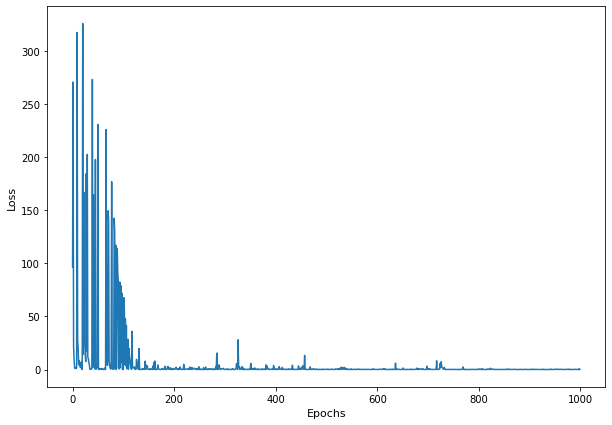

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='static')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

##torch.no_grad的效果說明

In [10]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
  y = m*x + b
  return y
y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.], grad_fn=<AddBackward0>)

In [11]:
y.grad_fn

In [12]:
with torch.no_grad():
  y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.])

In [13]:
y.grad_fn

In [14]:
y = linear_model(torch.Tensor([4.]),m,b)
y.backward()
m.grad

tensor([4.])

In [15]:
b.grad

tensor([1.])

# 程式 3.4： 測試Q網路

In [16]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

## 測試模型（static mode)

In [ ]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

## 測試模型 (random mode）

In [ ]:
test_model(model, 'random') #將游戲的生成模式改成random，再次測試模型

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['+' ' ' ' ' ' ']
 ['W' ' ' ' ' '-']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' 'P' ' ']
 ['W' ' ' ' ' '-']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' 'P' ' ' ' ']
 ['W' ' ' ' ' '-']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']
 ['W' ' ' ' ' '-']]
Game won! Reward: 10
True


True

## 將程式3.3的遊戲生成模式改成random，並進行1000次訓練

Text(0, 0.5, 'Loss')

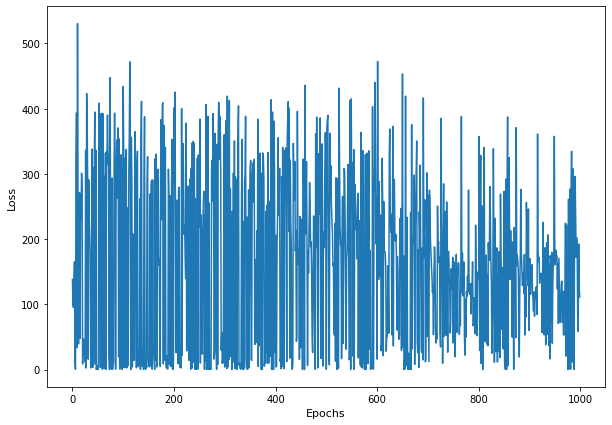

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 將程式3.3的遊戲生成模式改成player，並進行1000次訓練

Text(0, 0.5, 'Loss')

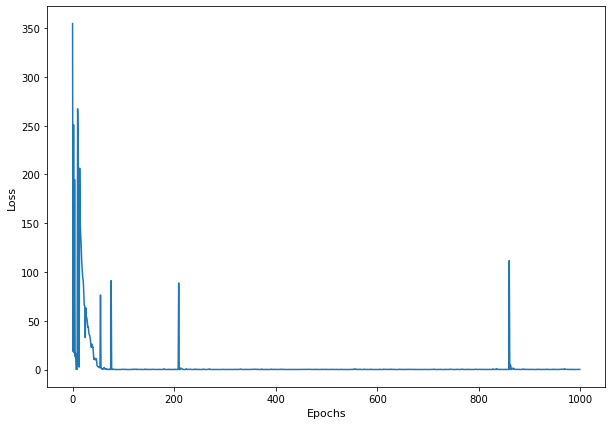

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 重建模型（同程式3.2）

In [17]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

# 程式 3.5: 包含經驗回放的DQN

Text(0, 0.5, 'Loss')

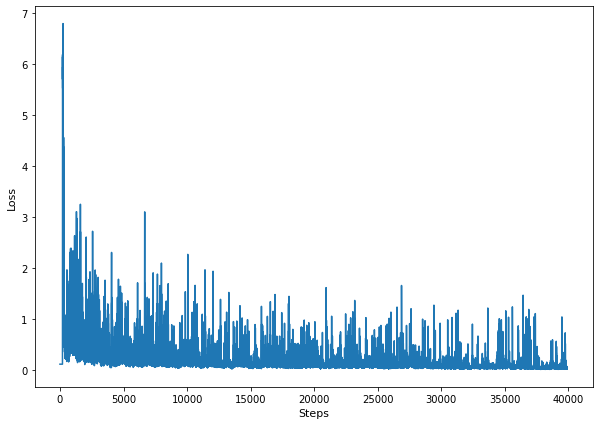

In [ ]:
from collections import deque
epochs = 5000 #訓練5000次
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
replay = deque(maxlen=mem_size) #產生一個記憶串列（資料型別為deque）來儲存經驗回放的資料，並將其命名為replay
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #記錄移動的步數，初始化為0
  while(status == 1):
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) #利用小批次資料中的『目前狀態批次』來計算Q值3
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
    losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 小編補充：gather()和unsqueeze()的函式說明

In [ ]:
t = torch.Tensor([ [1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]])
indices = torch.Tensor([ [2],
            [0],
            [1]])
torch.gather(input=t,dim=1,index=indices.long())

tensor([[3.],
        [4.],
        [8.]])

In [ ]:
x = torch.tensor([1,2,3,4])
y = torch.unsqueeze(input=x, dim=0) #在x張量的第0階加入一個1維的階
print(y.shape)

torch.Size([1, 4])


# 程式 3.6：測試具備經驗回放機制的模型

In [ ]:
max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

串流輸出內容已截斷至最後 5000 行。
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' 'P']
 ['W' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']
 ['-' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' 'P']
 ['W' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' '-' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['W' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['+' ' ' 'P' ' ']]
Move #: 3; Taking action: l
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['+' 'P' ' ' ' ']]
Move #: 4; Taking action: l
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' '+' ' ' ' ']
 [' ' 'W

# 程式 3.7： 目標網路

In [18]:
import copy
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度


model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0


action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 程式 3.8： 利用經驗回放和目標網路訓練DQN

In [ ]:
from collections import deque
from Gridworld import Gridworld
import copy
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度


model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0


action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}


game = Gridworld(size=4, mode='static')
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定批次大小
replay = deque(maxlen=mem_size)
max_moves = 50
sync_freq = 500 #設定Q網路和目標網路的參數同步頻率（每500步就同步一次參數）
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

j=0 #記錄當前訓練次數
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0
  while(status == 1):
    j+=1 #將訓練次數加1
    mov += 1
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False
    exp =  (state1, action_, reward, state2, done)
    replay.append(exp)
    state1 = state2
    if len(replay) > batch_size:
      minibatch = random.sample(replay, batch_size)
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch)
      with torch.no_grad():     #用目標網路模型計算Q值, 但不要優化模型的參數
        Q2 = model2(state2_batch)
      Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()

      loss = loss_fn(X, Y.detach())
      print("here")
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if j % sync_freq == 0: #每500步，就將Q網路當前的參數複製一份給目標網路
        model2.load_state_dict(model.state_dict())
    if reward != -1 or mov > max_moves:
      status = 0
      mov = 0

    losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 測試勝率

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

# 3.8 Pytorch lighting

In [19]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 51.0 MB/s eta 0:00:00


# This part is HW5

test 結果

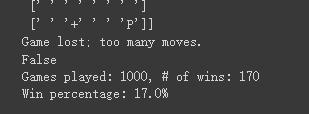

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 25.3 K
1 | target_model | Sequential | 25.3 K
2 | loss_fn      | MSELoss    | 0     
--------------------------------------------
50.7 K    Trainable params
0         Non-trainable params
50.7 K    Total params
0.203     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the t

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3500` reached.


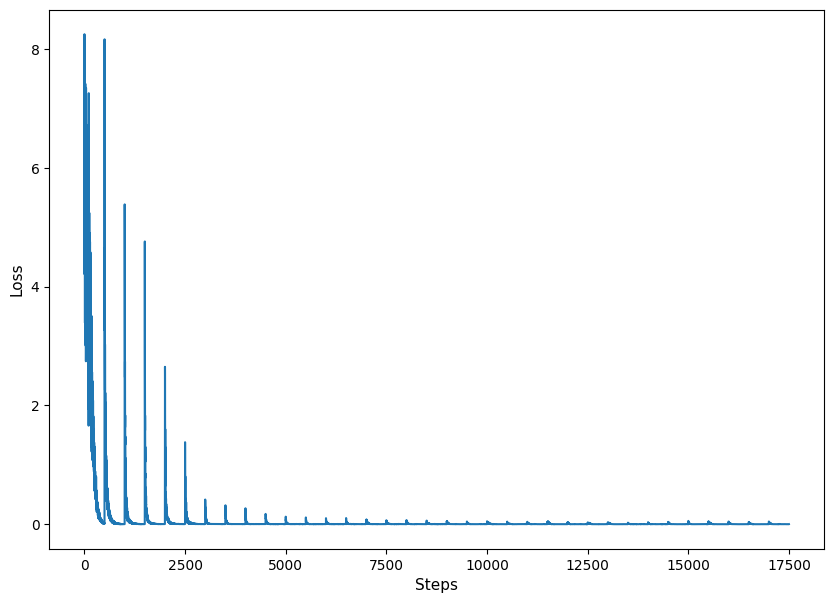

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset

# Integrate GridBoard and Gridworld classes
from GridBoard import GridBoard
from Gridworld import Gridworld

class ReplayBuffer(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        return self.buffer[idx]

class DQNModel(pl.LightningModule):
    def __init__(self, state_size, action_size, mem_size=1000, batch_size=200, sync_freq=500, gamma=0.99, lr=0.001):
        super(DQNModel, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=mem_size)
        self.batch_size = batch_size
        self.sync_freq = sync_freq
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.losses = []

        # Define the model
        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

        # Target model
        self.target_model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        self.target_model.load_state_dict(self.model.state_dict())

        # Loss function
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch
        Q1 = self.model(state1_batch)
        with torch.no_grad():
            Q2 = self.target_model(state2_batch)
        Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = self.loss_fn(X, Y.detach())
        self.losses.append(loss.item())

        # Sync target model
        if self.global_step % self.sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

    def collate_fn(self, minibatch):
        state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
        action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
        reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
        state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
        done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
        return state1_batch, action_batch, reward_batch, state2_batch, done_batch

    def add_experience(self, experience):
        self.memory.append(experience)

    def train_dataloader(self):
        return DataLoader(ReplayBuffer(self.memory), batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)

action_set = {
    0: 'u', # '0' represents 'up'
    1: 'd', # '1' represents 'down'
    2: 'l', # '2' represents 'left'
    3: 'r' # '3' represents 'right'
}
max_moves = 50

# Create a LightningModule instance
model = DQNModel(state_size=64, action_size=4)

# Simulate the environment and populate the memory
for i in range(100):  # Simulating 100 games to populate the memory
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < model.epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward != -1 else False
        exp = (state1, action_, reward, state2, done)
        model.add_experience(exp)
        state1 = state2
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
    if model.epsilon > 0.1:
        model.epsilon -= (1 / 5000)  # Decay epsilon over 5000 games

trainer = Trainer(max_epochs=3500)  # Increase max_epochs to 1000 for more training
trainer.fit(model)

plt.figure(figsize=(10, 7))
plt.plot(model.losses)
plt.xlabel("Steps", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.show()


# Test For HW5

In [21]:
from GridBoard import GridBoard
from Gridworld import Gridworld
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
        pass
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

串流輸出內容已截斷至最後 5000 行。
 ['P' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 14; Taking action: d
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 15; Taking action: l
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Game lost; too many moves.
False
Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 0; Taking action: u
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 ['P' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' '+']
 [' ' '-' ' 

# Add Callback : early stop and tensorboard

test 結果

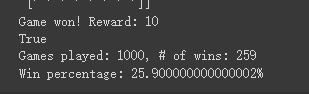

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 25.3 K
1 | target_model | Sequential | 25.3 K
2 | loss_fn      | MSELoss    | 0     
--------------------------------------------
50.7 K    Trainable params
0         Non-trainable params
50.7 K    Total params
0.203     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 10.643
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 5: 'train_loss' reached 10.64269 (best 10.64269), saving model to 'tb_logs/DQNModel/version_8/checkpoints/epoch=0-step=5.ckpt' as top 1
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 3.588 >= min_delta = 0.01. New best score: 7.055
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 10: 'train_loss' reached 7.05464 (best 7.05464), saving model to 'tb_logs/DQNModel/version_8/checkpoints/epoch=1-step=10.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 15: 'train_loss' was not in top 1
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.362 >= min_delta = 0.01. New best score: 6.693
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 20: 'train_loss' reached 6.69265 (best 6.69265), saving model to 'tb_logs/DQNModel/ve

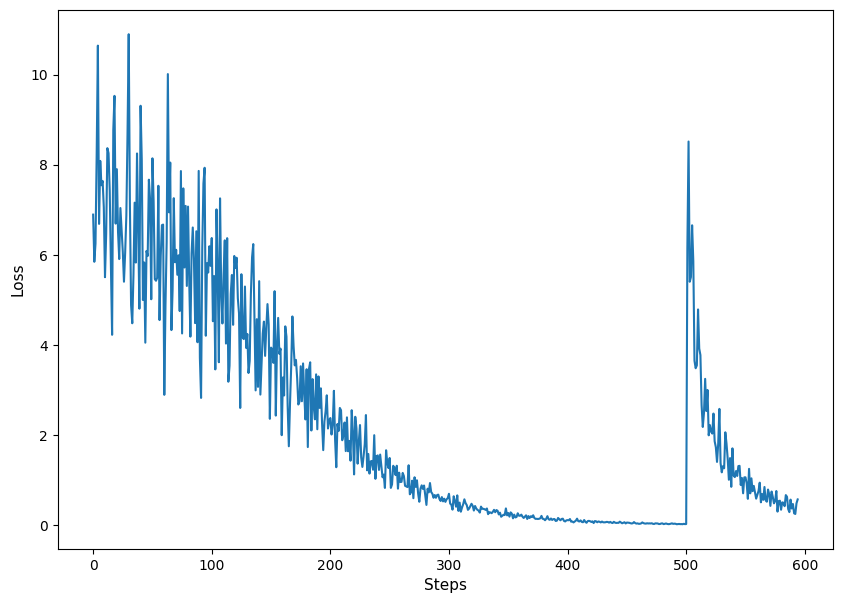

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader, Dataset

# Integrate GridBoard and Gridworld classes
from GridBoard import GridBoard
from Gridworld import Gridworld

class ReplayBuffer(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        return self.buffer[idx]

class DQNModel(pl.LightningModule):
    def __init__(self, state_size, action_size, mem_size=1000, batch_size=200, sync_freq=500, gamma=0.99, lr=0.001):
        super(DQNModel, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=mem_size)
        self.batch_size = batch_size
        self.sync_freq = sync_freq
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.losses = []

        # Define the model
        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

        # Target model
        self.target_model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        self.target_model.load_state_dict(self.model.state_dict())

        # Loss function
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch
        Q1 = self.model(state1_batch)
        with torch.no_grad():
            Q2 = self.target_model(state2_batch)
        Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = self.loss_fn(X, Y.detach())
        self.losses.append(loss.item())

        # Sync target model
        if self.global_step % self.sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

    def collate_fn(self, minibatch):
        state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
        action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
        reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
        state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
        done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
        return state1_batch, action_batch, reward_batch, state2_batch, done_batch

    def add_experience(self, experience):
        self.memory.append(experience)

    def train_dataloader(self):
        return DataLoader(ReplayBuffer(self.memory), batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)

action_set = {
    0: 'u', # '0' represents 'up'
    1: 'd', # '1' represents 'down'
    2: 'l', # '2' represents 'left'
    3: 'r' # '3' represents 'right'
}
max_moves = 50

# Create a LightningModule instance
model = DQNModel(state_size=64, action_size=4)

# Simulate the environment and populate the memory
for i in range(100):  # Simulating 100 games to populate the memory
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < model.epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward != -1 else False
        exp = (state1, action_, reward, state2, done)
        model.add_experience(exp)
        state1 = state2
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
    if model.epsilon > 0.1:
        model.epsilon -= (1 / 5000)  # Decay epsilon over 5000 games

# Callbacks
early_stop_callback = EarlyStopping(monitor='train_loss', min_delta=0.01, patience=20, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='train_loss', mode='min', save_top_k=1, verbose=True)
logger = TensorBoardLogger("tb_logs", name="DQNModel")

trainer = Trainer(max_epochs=3500, callbacks=[early_stop_callback, checkpoint_callback], logger=logger)
trainer.fit(model)

plt.figure(figsize=(10, 7))
plt.plot(model.losses)
plt.xlabel("Steps", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.show()


In [42]:
from GridBoard import GridBoard
from Gridworld import Gridworld
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
        pass
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

串流輸出內容已截斷至最後 5000 行。
[[' ' ' ' '+' ' ']
 ['-' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 14; Taking action: r
[[' ' ' ' '+' ' ']
 ['-' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 15; Taking action: r
[[' ' ' ' '+' ' ']
 ['-' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game lost; too many moves.
False
Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' 'P' ' ' 'W']]
Move #: 5; Taking action: d
[[' ' ' ' ' 

# 下面是測試(非作業)

# Test : Using Gridworld Created by chatgpt (Not Homework)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 19.2 K
1 | target_model | Sequential | 19.2 K
2 | loss_fn      | MSELoss    | 0     
--------------------------------------------
38.4 K    Trainable params
0         Non-trainable params
38.4 K    Total params
0.154     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the t

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


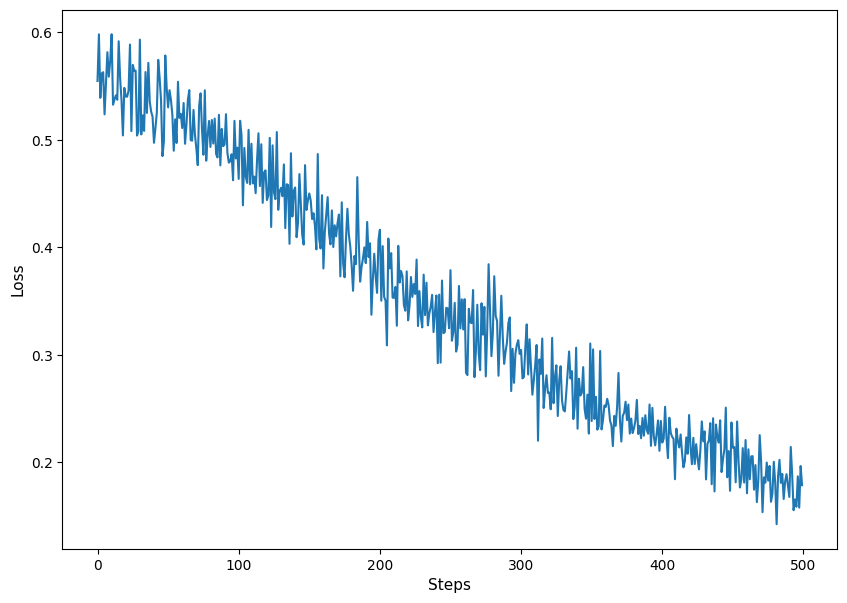

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from Gridworld import Gridworld
class ReplayBuffer(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        return self.buffer[idx]

class DQNModel(pl.LightningModule):
    def __init__(self, state_size, action_size, mem_size=1000, batch_size=200, sync_freq=500, gamma=0.99, lr=0.001):
        super(DQNModel, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=mem_size)
        self.batch_size = batch_size
        self.sync_freq = sync_freq
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.losses = []

        # Define the model
        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

        # Target model
        self.target_model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        self.target_model.load_state_dict(self.model.state_dict())

        # Loss function
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch
        Q1 = self.model(state1_batch)
        with torch.no_grad():
            Q2 = self.target_model(state2_batch)
        Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = self.loss_fn(X, Y.detach())
        self.losses.append(loss.item())

        # Sync target model
        if self.global_step % self.sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

    def collate_fn(self, minibatch):
        state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
        action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
        reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
        state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
        done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
        return state1_batch, action_batch, reward_batch, state2_batch, done_batch

    def add_experience(self, experience):
        self.memory.append(experience)

    def train_dataloader(self):
        return DataLoader(ReplayBuffer(self.memory), batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)

class Gridworld:
    # Mocking the Gridworld class for completeness
    def __init__(self, size, mode):
        self.size = size
        self.board = self.Board(size)

    class Board:
        def __init__(self, size):
            self.size = size

        def render_np(self):
            return np.random.rand(self.size, self.size)

    def makeMove(self, action):
        pass

    def reward(self):
        return random.choice([-1, 0, 1])

action_set = {
    0: 'u', # '0' represents 'up'
    1: 'd', # '1' represents 'down'
    2: 'l', # '2' represents 'left'
    3: 'r' # '3' represents 'right'
}
max_moves = 50

# Create a LightningModule instance
model = DQNModel(state_size=16, action_size=4)

# Simulate the environment and populate the memory
for i in range(5000):  # Simulating 5000 games to populate the memory
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, 16) + np.random.rand(1, 16) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < model.epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 16) + np.random.rand(1, 16) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward != -1 else False
        exp = (state1, action_, reward, state2, done)
        model.add_experience(exp)
        state1 = state2
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
    if model.epsilon > 0.1:
        model.epsilon -= (1 / 5000)  # Decay epsilon over 5000 games

trainer = Trainer(max_epochs=100)  # Increase max_epochs to 10 for more training
trainer.fit(model)

plt.figure(figsize=(10, 7))
plt.plot(model.losses)
plt.xlabel("Steps", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.show()


In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      #print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        #print(test_game.display())
        pass
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

串流輸出內容已截斷至最後 5000 行。
Move #: 3; Taking action: r
Move #: 4; Taking action: l
Move #: 5; Taking action: l
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: u
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: r
Move #: 1; Taking action: u
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: l
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: d
Move #: 1; Taking action: d
Move #: 2; Taking action: r
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: d
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: d
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: d
Move #: 1; Taking action: u
Move #: 2; Taking action: d
Move #: 3; Taking action: u
Move #: 4; Taking action: u
Move #: 5; Taking action: l
Move #: 6; Taking action: u
Move #: 7; Taking action: l
Move #: 8; Taking action: l
Game won! Reward: 1
True
Initial State:
Move #: 0; Taking action: u
Game won! Reward: 1
True
Initial State:
Mov

In [ ]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install -q torch torchvision --upgrade

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
from collections import deque
import pytorch_lightning as pl
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class GridworldDataset(torch.utils.data.Dataset):
    def __init__(self, replay_memory):
        self.replay_memory = replay_memory

    def __len__(self):
        return len(self.replay_memory)

    def __getitem__(self, idx):
        return self.replay_memory[idx]

class GridworldModel(pl.LightningModule):
    def __init__(self, mem_size=1000, batch_size=200, gamma=0.99, epsilon_decay=1e-4):
        super(GridworldModel, self).__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.epsilon = 1.0
        self.replay = deque(maxlen=self.mem_size)
        self.model = QNetwork()
        self.target_model = QNetwork()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def loss(self, X, Y):
        return F.mse_loss(X, Y)

    def remember(self, experience):
        self.replay.append(experience)

    def epsilon_decay_step(self):
        self.epsilon -= self.epsilon_decay
        self.epsilon = max(0.1, self.epsilon)

    def train_dataloader(self):
        dataset = GridworldDataset(self.replay)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    def training_step(self, batch, batch_idx):
      state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch

      Q1 = self.forward(state1_batch)
      with torch.no_grad():
          Q2 = self.target_model(state2_batch)

      # Reshape the reward_batch tensor to match the shape of the operation result
      reward_batch = reward_batch.view(-1, 1)
      done_batch = done_batch.view(-1, 1)
      # print("Shape of reward_batch:", reward_batch.shape)
      # print("Shape of done_batch:", done_batch.shape)
      # print("Shape of Q2:", Q2.shape)
      Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=2)[0])

      # Ensure action indices are within bounds
      num_actions = Q1.size(2)
      action_batch = action_batch.view(-1, 1, 1)
      action_batch = torch.clamp(action_batch, 0, num_actions - 1)
      # print("Shape of action_batch:", action_batch.shape)
      # print("Shape of Q1:", Q1.shape)
      X = Q1.gather(dim=2, index=action_batch.long()).squeeze(2)

      loss = self.loss(X, Y.detach())
      self.log('train_loss', loss)
      return loss


    def on_epoch_end(self):
        self.epsilon_decay_step()
        if self.current_epoch % sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

class GridworldDataModule(pl.LightningDataModule):
    def __init__(self, mem_size, model):
        super(GridworldDataModule, self).__init__()
        self.mem_size = mem_size
        self.model = model

    def prepare_data(self):
        # Initialize the game environment and populate replay memory
        self.game = Gridworld(size=4, mode='random')
        #action_set = ['up', 'down', 'left', 'right']
        for _ in range(self.mem_size):
            state1_ = self.game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state1 = torch.from_numpy(state1_).float()
            action_ = np.random.randint(0, 4)
            action = action_set[action_]
            self.game.makeMove(action)
            state2_ = self.game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state2 = torch.from_numpy(state2_).float()
            reward = self.game.reward()
            done = 1 if reward != -1 else 0  # Convert boolean to integer
            self.model.remember((state1, action_, reward, state2, done))  # Ensure done is integer

    def train_dataloader(self):
        dataset = GridworldDataset(self.model.replay)
        return DataLoader(dataset, batch_size=self.model.batch_size, shuffle=True)



# Parameters
epochs = 5000
mem_size = 1000
batch_size = 200
gamma = 0.99
epsilon_decay = 1 / epochs
sync_freq = 500

# Initialize Lightning Model
model = GridworldModel(mem_size=mem_size, batch_size=batch_size, gamma=gamma, epsilon_decay=epsilon_decay)
data_module = GridworldDataModule(mem_size=mem_size, model=model)

# Initialize Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, datamodule=data_module)



# # Plotting losses
# train_losses = trainer.callback_metrics['train_loss']

# # Plotting losses
# plt.plot(train_losses, label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.legend()
# plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type     | Params
------------------------------------------
0 | model        | QNetwork | 25.3 K
1 | target_model | QNetwork | 25.3 K
------------------------------------------
50.7 K    Trainable params
0         Non-trainable params
50.7 K    Total params
0.203     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def test_model(model, mode='random', max_games=1000):
    wins = 0
    state_size = 64  # Assuming this is the size of your state
    #action_set = ['up', 'down', 'left', 'right']  # Assuming this is your action set
    for i in range(max_games):
        game = Gridworld(size=4, mode=mode)  # Assuming Gridworld is imported and initialized elsewhere
        state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
        state = torch.from_numpy(state).float()
        done = False
        while not done:
            q_values = model(state)
            action = torch.argmax(q_values).item()
            game.makeMove(action_set[action])
            state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
            state = torch.from_numpy(state).float()
            reward = game.reward()
            done = reward == 10 or reward == -1
            print(f"Game {i+1}, Reward: {reward}, Done: {done}")  # Add this line for debugging
        if reward == 10:
            wins += 1
    return wins

win_percentage = test_model(model)
print(f"Win percentage: {win_percentage}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
from collections import deque
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Assuming you have Gridworld and other necessary classes implemented and imported

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class GridworldDataset(torch.utils.data.Dataset):
    def __init__(self, replay_memory):
        self.replay_memory = replay_memory

    def __len__(self):
        return len(self.replay_memory)

    def __getitem__(self, idx):
        return self.replay_memory[idx]

class GridworldModel(pl.LightningModule):
    def __init__(self, mem_size=1000, batch_size=200, gamma=0.99, epsilon_decay=1e-4):
        super(GridworldModel, self).__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.epsilon = 1.0
        self.replay = deque(maxlen=self.mem_size)
        self.model = QNetwork()
        self.target_model = QNetwork()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def loss(self, X, Y):
        return F.mse_loss(X, Y)

    def remember(self, experience):
        self.replay.append(experience)

    def epsilon_decay_step(self):
        self.epsilon -= self.epsilon_decay
        self.epsilon = max(0.1, self.epsilon)

    def train_dataloader(self):
        dataset = GridworldDataset(self.replay)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def training_step(self, batch, batch_idx):
      state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch

      Q1 = self.forward(state1_batch)
      with torch.no_grad():
          Q2 = self.target_model(state2_batch)

      # Reshape the reward_batch tensor to match the shape of the operation result
      reward_batch = reward_batch.view(-1, 1)
      done_batch = done_batch.view(-1, 1)
      # print("Shape of reward_batch:", reward_batch.shape)
      # print("Shape of done_batch:", done_batch.shape)
      # print("Shape of Q2:", Q2.shape)
      Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=2)[0])

      # Ensure action indices are within bounds
      num_actions = Q1.size(2)
      action_batch = action_batch.view(-1, 1, 1)
      action_batch = torch.clamp(action_batch, 0, num_actions - 1)
      # print("Shape of action_batch:", action_batch.shape)
      # print("Shape of Q1:", Q1.shape)
      X = Q1.gather(dim=2, index=action_batch.long()).squeeze(2)

      loss = self.loss(X, Y.detach())
      self.log('train_loss', loss)
      return loss



    def on_epoch_end(self):
        self.epsilon_decay_step()
        if self.current_epoch % sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

class GridworldDataModule(pl.LightningDataModule):
    def __init__(self, mem_size, model):
        super(GridworldDataModule, self).__init__()
        self.mem_size = mem_size
        self.model = model

    def prepare_data(self):
        # Initialize the game environment and populate replay memory
        self.game = Gridworld(size=4, mode='random')
        #action_set = ['up', 'down', 'left', 'right']
        for _ in range(self.mem_size):
            state1_ = self.game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state1 = torch.from_numpy(state1_).float()
            action_ = np.random.randint(0, 4)
            action = action_set[action_]
            self.game.makeMove(action)
            state2_ = self.game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state2 = torch.from_numpy(state2_).float()
            reward = self.game.reward()
            done = 1 if reward != -1 else 0
            self.model.remember((state1, action_, reward, state2, done))

    def train_dataloader(self):
        dataset = GridworldDataset(self.model.replay)
        return DataLoader(dataset, batch_size=self.model.batch_size, shuffle=True)


def test_model(model, mode='random', max_games=1000):
    wins = 0
    state_size = 64  # Assuming this is the size of your state
    action_set = ['up', 'down', 'left', 'right']  # Assuming this is your action set
    for i in range(max_games):
        game = Gridworld(size=4, mode=mode)  # Assuming Gridworld is imported and initialized elsewhere
        state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
        state = torch.from_numpy(state).float()
        done = False
        while not done:
            q_values = model(state)
            action = torch.argmax(q_values).item()
            game.makeMove(action_set[action])
            state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
            state = torch.from_numpy(state).float()
            reward = game.reward()
            done = reward == 10 or reward == -1
            #print(f"Game {i+1}, Reward: {reward}, Done: {done}")  # For debugging
        if reward == 10:
            wins += 1
    return wins

# Parameters
epochs = 5000
mem_size = 1000
batch_size = 200
gamma = 0.99
epsilon_decay = 1 / epochs
sync_freq = 500

# Initialize Lightning Model
model = GridworldModel(mem_size=mem_size, batch_size=batch_size, gamma=gamma, epsilon_decay=epsilon_decay)
data_module = GridworldDataModule(mem_size=mem_size, model=model)

# Initialize Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, datamodule=data_module)

win_percentage = test_model(model)
print(f"Win percentage: {win_percentage}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from collections import deque
import pytorch_lightning as pl

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class GridworldDataset(torch.utils.data.Dataset):
    def __init__(self, replay_memory):
        self.replay_memory = replay_memory

    def __len__(self):
        return len(self.replay_memory)

    def __getitem__(self, idx):
        return self.replay_memory[idx]

class GridworldModel(pl.LightningModule):
    def __init__(self, mem_size=1000, batch_size=200, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.9995, sync_freq=500):
        super(GridworldModel, self).__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.sync_freq = sync_freq
        self.replay = deque(maxlen=self.mem_size)
        self.model = QNetwork()
        self.target_model = QNetwork()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def loss(self, X, Y):
        return F.mse_loss(X, Y)

    def remember(self, experience):
        self.replay.append(experience)

    def epsilon_decay_step(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_end)

    def train_dataloader(self):
        dataset = GridworldDataset(self.replay)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def training_step(self, batch, batch_idx):
      state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch

      Q1 = self.forward(state1_batch)
      with torch.no_grad():
          Q2 = self.target_model(state2_batch)

      # Reshape the reward_batch tensor to match the shape of the operation result
      reward_batch = reward_batch.view(-1, 1)
      done_batch = done_batch.view(-1, 1)
      # print("Shape of reward_batch:", reward_batch.shape)
      # print("Shape of done_batch:", done_batch.shape)
      # print("Shape of Q2:", Q2.shape)
      Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=2)[0])

      # Ensure action indices are within bounds
      num_actions = Q1.size(2)
      action_batch = action_batch.view(-1, 1, 1)
      action_batch = torch.clamp(action_batch, 0, num_actions - 1)
      # print("Shape of action_batch:", action_batch.shape)
      # print("Shape of Q1:", Q1.shape)
      X = Q1.gather(dim=2, index=action_batch.long()).squeeze(2)

      loss = self.loss(X, Y.detach())
      self.log('train_loss', loss)
      return loss


    def on_epoch_end(self):
        self.epsilon_decay_step()
        if self.current_epoch % self.sync_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

class GridworldDataModule(pl.LightningDataModule):
    def __init__(self, mem_size, model):
        super(GridworldDataModule, self).__init__()
        self.mem_size = mem_size
        self.model = model

    def prepare_data(self):
        # Initialize the game environment and populate replay memory
        game = Gridworld(size=4, mode='random')  # Assuming Gridworld is initialized elsewhere
        #action_set = ['up', 'down', 'left', 'right']
        for _ in range(self.mem_size):
            state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state1 = torch.from_numpy(state1_).float()
            action_ = np.random.randint(0, 4)
            action = action_set[action_]
            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()
            done = 1 if reward != -1 else 0
            self.model.remember((state1, action_, reward, state2, done))

    def train_dataloader(self):
        dataset = GridworldDataset(self.model.replay)
        return DataLoader(dataset, batch_size=self.model.batch_size, shuffle=True)

def test_model(model, mode='random', max_games=1000):
    wins = 0
    state_size = 64
    #action_set = ['up', 'down', 'left', 'right']
    for i in range(max_games):
        game = Gridworld(size=4, mode=mode)  # Assuming Gridworld is initialized elsewhere
        state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
        state = torch.from_numpy(state).float()
        done = False
        while not done:
            q_values = model(state)
            action = torch.argmax(q_values).item()
            game.makeMove(action_set[action])
            state = game.board.render_np().reshape(1, state_size) + np.random.rand(1, state_size) / 100.0
            state = torch.from_numpy(state).float()
            reward = game.reward()
            done = reward == 10 or reward == -1
        if reward == 10:
            wins += 1
    return wins

# Parameters
epochs = 500
mem_size = 1000
batch_size = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.9995
sync_freq = 50  # Increased sync frequency

# Initialize Lightning Model
model = GridworldModel(mem_size=mem_size, batch_size=batch_size, gamma=gamma, epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay, sync_freq=sync_freq)
data_module = GridworldDataModule(mem_size=mem_size, model=model)

# Initialize Lightning Trainer
trainer =pl.Trainer(max_epochs=epochs)
trainer.fit(model, datamodule=data_module)

win_percentage = test_model(model)
print(f"Win percentage: {win_percentage}%")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type     | Params
------------------------------------------
0 | model        | QNetwork | 25.3 K
1 | target_model | QNetwork | 25.3 K
------------------------------------------
50.7 K    Trainable params
0         Non-trainable params
50.7 K    Total params
0.203     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Win percentage: 0%


# 程式 3.5 改良版 （加入『學習避免撞牆』機制）

串流輸出內容已截斷至最後 5000 行。
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' 'P' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'P' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 2; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Game won! Reward: 10
True
Initial State:
[[' ' '+' ' ' '-']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' '+' ' ' '-']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' '+' 'P' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' '+' ' ' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' ' ' '+' '-']
 [' ' ' ' ' ' 

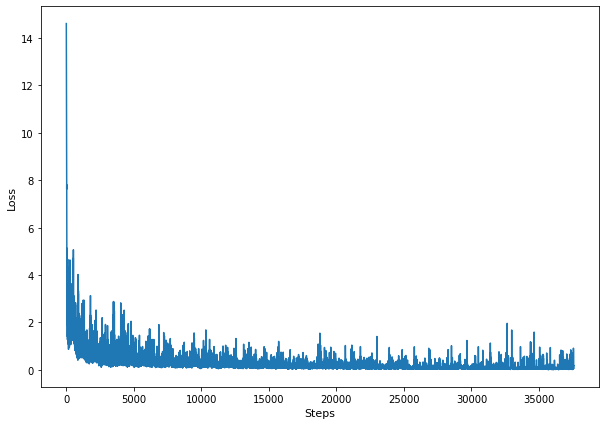

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3  #超參數『α』
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

gamma = 0.9
epsilon = 1.0

#————————————————

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
move_pos = [(-1,0),(1,0),(0,-1),(0,1)]   #●移動方向 u,d,l,r 的實際移動向量
replay = deque(maxlen=mem_size) #產生一個deque串列來儲存經驗回放的資料
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #移動的步數
  while(status == 1):
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    hit_wall = game.validateMove('Player', move_pos[action_]) == 1 #●若有撞牆的動作，hit_wall就為True
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #{5}將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) #利用小批次資料中的目前狀態來計算Q值
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #gather()及unsqueeze()函式的用途可參見下面的小編補充框
      loss = loss_fn(X, Y.detach())
      if i%100 == 0:
        print(i, loss.item())
        clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

#——————————————

max_games = 1000
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random')
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率